In [1]:
# nn.BCELoss().to(device)
# test22

In [1]:
import os
import time
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import tarfile
import random
import json
from shutil import copyfile
from torchsummary import summary 

c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fix all seeds to make experiments reproducible
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
np.random.seed(2024)
random.seed(2024)
torch.backends.cudnn.deterministic = True

In [3]:
# Simple dataloader and label binarization, 
# that is converting test labels into binary arrays of length 22 
# (number of classes) with 1 in places of applicable labels).
class MpstDataset(Dataset):
    def __init__(self, data_path, anno_path, transforms, split_type):
        self.transforms = transforms
        self.split_type= split_type
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = [] # 이미지 이름
        self.annos = [] # 태그 이름
        self.data_path = data_path
        print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            self.annos.append(sample['image_labels'])
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float) # labeling one-hot encoding

    def __getitem__(self, item):
        anno = self.annos[item]    
        img_path = os.path.join(self.data_path, self.split_type, self.imgs[item])
        img_path += '.png'
        img = Image.open(img_path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img, anno

    def __len__(self):
        return len(self.imgs)

In [4]:
img_folder=r'E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024_mood_extracted2_split'
split_test='test'
dataset_test = MpstDataset(img_folder, os.path.join(img_folder, 'test', 'test_mood.json'), None, split_test)

print(f"test dataset 개수: {len(dataset_test)}")


loading E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024_mood_extracted2_split\test\test_mood.json
test dataset 개수: 123


Label Tag Distribution (count, class name): [(1, 'sentimental'), (2, 'cute'), (2, 'comic'), (3, 'depressing'), (4, 'bleak'), (4, 'inspiring'), (4, 'feel-good'), (6, 'horror'), (6, 'dramatic'), (7, 'tragedy'), (7, 'fantasy'), (7, 'dark'), (7, 'atmospheric'), (8, 'boring'), (10, 'sadist'), (11, 'mystery'), (15, 'action'), (16, 'suspenseful'), (17, 'humor'), (36, 'romantic'), (36, 'comedy'), (57, 'violence')]


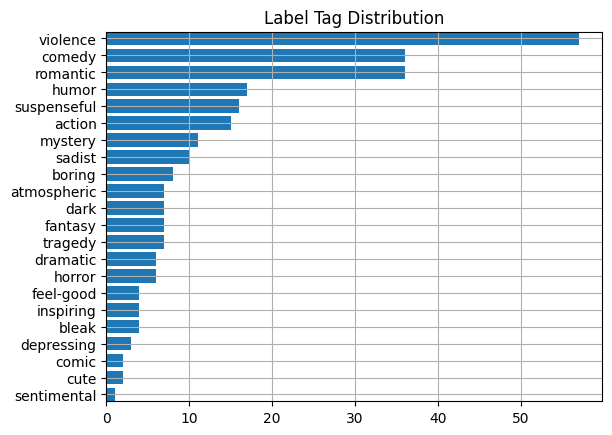

In [5]:
# Calculate label distribution for the entire dataset (train + val)
samples = dataset_test.annos 
samples = np.array(samples)
with printoptions(precision=3, suppress=True):
    class_counts = np.sum(samples, axis=0)
    # Sort labels according to their frequency in the dataset.
    sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
    print('Label Tag Distribution (count, class name):', list(zip(class_counts[sorted_ids].astype(int), np.array(dataset_test.classes)[sorted_ids])))
    # plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
    plt.barh(range(len(dataset_test.classes)), width=class_counts[sorted_ids])
    plt.yticks(range(len(dataset_test.classes)), np.array(dataset_test.classes)[sorted_ids])
    plt.gca().margins(y=0)
    plt.grid()
    plt.title('Label Tag Distribution')
    plt.show()

In [6]:
# Use the torchvision's implementation of ResNet, 
# but add FC layer for a different number of classes (22)
# and a Sigmoid instead of a default Softmax.
class Resnet50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [7]:
# Use threshold to define predicted labels 
# and invoke sklearn's metrics with different averaging strategies.
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            
            # 'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            # 'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            # 'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            
            'weighted/precision': precision_score(y_true=target, y_pred=pred, average='weighted'),
            'weighted/recall': recall_score(y_true=target, y_pred=pred, average='weighted'),
            'weighted/f1': f1_score(y_true=target, y_pred=pred, average='weighted'),
            
            'accuracy': accuracy_score(y_true=target, y_pred=pred)
            }

In [8]:
# Initialize the training parameters.
num_workers = 0 # 8 # Number of CPU processes for data preprocessing
lr = 1e-4 # Learning rate
batch_size = 32
save_freq = 1 # Save checkpoint frequency (epochs)
max_epoch_number = 100 # Number of epochs for training 
# Note: on the small subset of data overfitting happens after 30-35 epochs

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

device = torch.device('cuda')

In [9]:
# Save path for checkpoints
save_path = './checkpoints/test25'

In [10]:
# Run inference on the test data
# test preprocessing
from torchvision import transforms
import os

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
split_test='test'

img_folder=r'E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024_mood_extracted2_split'
split_test='test'

test_annotations = os.path.join(img_folder, 'test', 'test_mood.json')
test_dataset = MpstDataset(img_folder, test_annotations, test_transform, split_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                                num_workers=num_workers)


loading E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024_mood_extracted2_split\test\test_mood.json


In [18]:
img_folder=r'E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024_mood_extracted2_split'
split_train='train'
split_val='val'

# val preprocessing
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
print(tuple(np.array(np.array(mean)*255).tolist()))

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(),
    # transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
    #                         shear=None, 
    #                         # resample=False, 
    #                         # fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    #                         fill=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# Initialize the dataloaders for training.
val_annotations = os.path.join(img_folder, 'val', 'val_mood.json')
train_annotations = os.path.join(img_folder, 'train',
                                 'train_mood.json')

val_dataset = MpstDataset(img_folder, val_annotations, val_transform, split_val)
train_dataset = MpstDataset(img_folder, train_annotations, train_transform, split_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                              # drop_last=True
                              )
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

num_train_batches = int(np.ceil(len(train_dataset) / batch_size))
num_val_batches = int(np.ceil(len(val_dataset) / batch_size))
print(f"num_train_batches: {num_train_batches}")
print(f"num_val_batches: {num_val_batches}")

(123.675, 116.28, 103.53)
loading E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024_mood_extracted2_split\val\val_mood.json
loading E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024_mood_extracted2_split\train\train_mood.json
num_train_batches: 18
num_val_batches: 4


In [11]:

# 저장된 ckpt를 불러와서 inference를 수행하는 경우
test_model = Resnet50(len(test_dataset.classes))
test_model = test_model.to(device)
test_model.load_state_dict( torch.load('./checkpoints/test25/checkpoint-000003.pth'))

test_model.eval()


c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [26]:
import json

item_list=[]
result_metric_list=[]    
test_acc=[]
for sample_id in range(len(train_dataset)):
    test_img, test_labels = train_dataset[sample_id]
    test_img_path = os.path.join(img_folder, 'train', train_dataset.imgs[sample_id])
    test_img_path+='.png'
    with torch.no_grad():
        raw_pred = test_model(test_img.unsqueeze(0).to(device)).cpu().numpy()[0]
        raw_pred = np.array(raw_pred > 0.5, dtype=float)
        
    acc=(raw_pred==test_labels).mean()
    test_acc.append(acc)
    # print(sample_id)
    # 평가지표 확인
    # print(classification_report(test_labels, raw_pred, digits=3))
    
    metrics={'imdb_id':train_dataset.imgs[sample_id]}
    result = calculate_metrics(raw_pred, test_labels)
    metrics.update(result)
    result_metric_list.append(metrics)
    
    predicted_labels = np.array(test_dataset.classes)[np.argwhere(raw_pred > 0)[:, 0]]
    if not len(predicted_labels):
        predicted_labels = np.array(['no pred']) # ['no predictions']
    img_labels = np.array(test_dataset.classes)[np.argwhere(test_labels > 0)[:, 0]]

    # 결과 가시화    
    # plt.imshow(Image.open(test_img_path).convert('RGB'))
    # plt.title("movie: {} \nPredicted labels: {} \nGT labels: {}".format(test_dataset.imgs[sample_id],', '.join(predicted_labels), ', '.join(img_labels)))
    # plt.axis('off')
    # plt.show()
    
    # json 파일 저장할 gt_labels, predicted_labels 딕셔너리
    item={'imdb_id': train_dataset.imgs[sample_id],
          'gt_labels': img_labels.tolist(),
          'predicted_labels': predicted_labels.tolist()
          }
    item_list.append(item)

c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NGN\anaconda3\envs\auto_tagging\lib\s

In [27]:
import pandas as pd
df_dict = pd.DataFrame(item_list)

In [28]:
print(df_dict)

       imdb_id                             gt_labels predicted_labels
0    tt0023427                            [violence]       [violence]
1    tt0029583             [romantic, fantasy, cute]       [romantic]
2    tt0031381                    [romantic, boring]       [romantic]
3    tt0032910                       [fantasy, cute]        [no pred]
4    tt0034492                                [cute]        [no pred]
..         ...                                   ...              ...
568  tt0104427                          [depressing]        [no pred]
569  tt0104438                              [comedy]        [no pred]
570  tt0104454                    [romantic, boring]       [romantic]
571  tt0104507  [romantic, atmospheric, sentimental]       [romantic]
572  tt0104550                            [romantic]       [romantic]

[573 rows x 3 columns]


In [29]:
import numpy as np
micro_precision_list=[]
micro_recall_list=[]
micro_f1_list=[]
weighted_precision_list=[]
weighted_recall_list=[]
weighted_f1_list=[]

for i in range(len(result_metric_list)):
    micro_precision_list.append(result_metric_list[i]['micro/precision'])
    micro_recall_list.append(result_metric_list[i]['micro/recall'])
    micro_f1_list.append(result_metric_list[i]['micro/f1'])
    weighted_precision_list.append(result_metric_list[i]['weighted/precision'])
    weighted_recall_list.append(result_metric_list[i]['weighted/recall'])
    weighted_f1_list.append(result_metric_list[i]['weighted/f1'])

print(f"micro_precision mean:{round(np.mean(micro_precision_list),5)}")
print(f"micro_recall mean:{round(np.mean(micro_recall_list),5)}")
print(f"micro_f1 mean:{round(np.mean(micro_f1_list),5)}")
print(f"weighted_precision mean: {round(np.mean(weighted_precision_list),5)}")
print(f"weighted_recall mean: {round(np.mean(weighted_recall_list),5)}")
print(f"weighted_f1 mean: {round(np.mean(weighted_f1_list),5)}")

micro_precision mean:0.92559
micro_recall mean:0.92559
micro_f1 mean:0.92559
weighted_precision mean: 0.90411
weighted_recall mean: 0.92559
weighted_f1 mean: 0.90162


In [30]:
correct_num=0
total_pt_num=0
for i in range(len(item_list)):
    for tag in item_list[i]['predicted_labels']:
        total_pt_num+=1
        if(tag in item_list[i]['gt_labels']):
            correct_num+=1
            
print(f"Total pd_tag count:{total_pt_num}\nIncluded in gt_tag count:{correct_num}")
print(f"Correct rate: {round(correct_num/total_pt_num*100,4)} ")

Total pd_tag count:616
Included in gt_tag count:371
Correct rate: 60.2273 


In [17]:
_test_acc=np.mean(test_acc)
print(f"Accuracy_mean:{round(_test_acc, 5)}")

Accuracy_mean:0.90244


In [60]:
df_dict.to_csv("./result/t22_e3_th40.csv")

In [61]:
with open('./result_sample/test22/e3_th40.json', 'w') as f:
    json.dump(item_list, f, indent=3)

In [62]:
import json
with open('./result_sample/test22/e3_th40_metric.json', 'w') as f:
    json.dump(result_metric_list, f, indent=3)